**Filename identifiers**:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Importing the required libraries and modules.

In [ ]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Convolution2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  #

Checking if GPU usage is active.

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Setting the working directory.

In [ ]:
os.chdir("/content/drive/MyDrive/data/RAVDESS")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/MyDrive/data/RAVDESS


Listing some of the sound files for Actor 1.

In [ ]:
dir_list = os.listdir("./Actor_01")
dir_list[0:5]

['03-01-01-01-01-01-01.wav',
 '03-01-01-01-02-02-01.wav',
 '03-01-02-01-01-01-01.wav',
 '03-01-01-01-01-02-01.wav',
 '03-01-02-01-02-01-01.wav']

Keeping only data with strong emotional intensity and label the data by actor gender and emotion.

In [ ]:
RAV = "./"
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for actor in dir_list:
    fname = os.listdir(RAV + actor)
    for f in fname:
        part = f.split('.')[0].split('-')
        if part[3] == "02":
          emotion.append(int(part[2]))
          temp = int(part[6])
          if temp%2 == 0:
              temp = "female"
          else:
              temp = "male"
          gender.append(temp)
          path.append(RAV + actor + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df

,gender,emotion,path
0,male,calm,./Actor_01/03-01-02-02-01-01-01.wav
1,male,calm,./Actor_01/03-01-02-02-02-02-01.wav
2,male,calm,./Actor_01/03-01-02-02-02-01-01.wav
3,male,calm,./Actor_01/03-01-02-02-01-02-01.wav
4,male,happy,./Actor_01/03-01-03-02-01-01-01.wav
...,...,...,...
667,female,disgust,./Actor_24/03-01-07-02-02-01-24.wav
668,female,surprise,./Actor_24/03-01-08-02-02-01-24.wav
669,female,surprise,./Actor_24/03-01-08-02-01-01-24.wav
670,female,disgust,./Actor_24/03-01-07-02-01-01-24.wav


Listing the number of samples per emotion.

In [ ]:
RAV_df.emotion.value_counts()

disgust     96
fear        96
calm        96
happy       96
sad         96
angry       96
surprise    96
Name: emotion, dtype: int64

Listing the number of samples per gender.

In [ ]:
RAV_df.gender.value_counts()

male      336
female    336
Name: gender, dtype: int64

Listening to a sample of a surprise emotion expressed by a female and check its waveform.

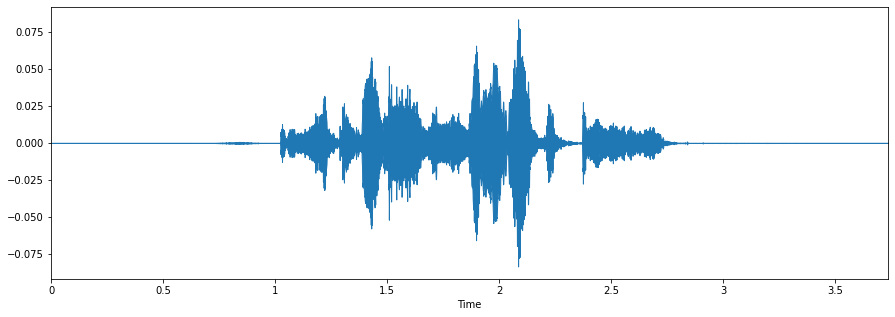

In [ ]:
fname = RAV + 'Actor_14/03-01-08-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
 
# Lets play the audio 
ipd.Audio(fname)

Listening to a sample of a surprise emotion expressed by a male and check its waveform.

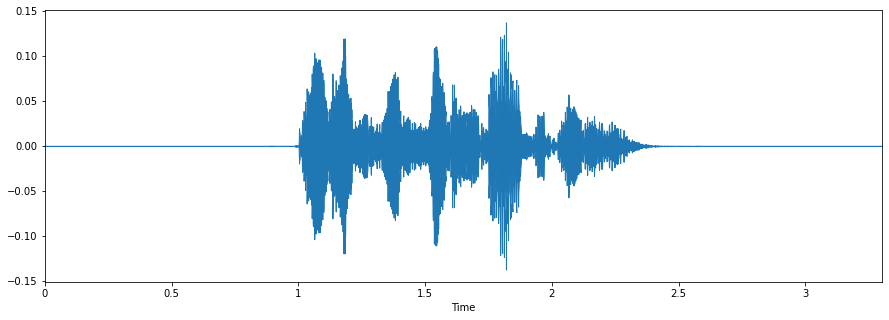

In [ ]:
fname = RAV + 'Actor_13/03-01-08-02-02-02-13.wav'  
data_2, sampling_rate_2 = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data_2, sr=sampling_rate_2)
 
# Lets play the audio 
ipd.Audio(fname)

### Mel-frequency cepstral coefficient (MFCC)

Transforming the previous waves into MFC representations and plot them.

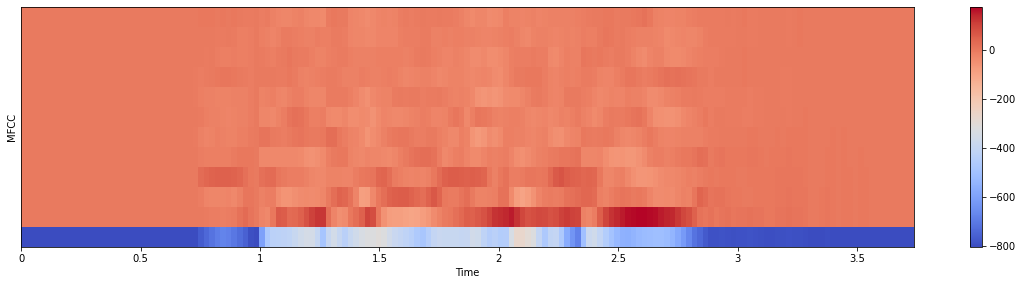

In [ ]:
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=12)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

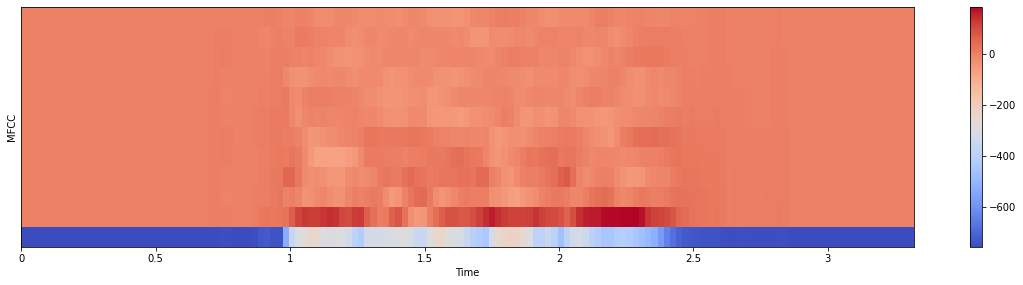

In [ ]:
mfcc = librosa.feature.mfcc(y=data_2, sr=sampling_rate_2, n_mfcc=12)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

Summarizing the values on the 12 MFCC bands via average and plot them.

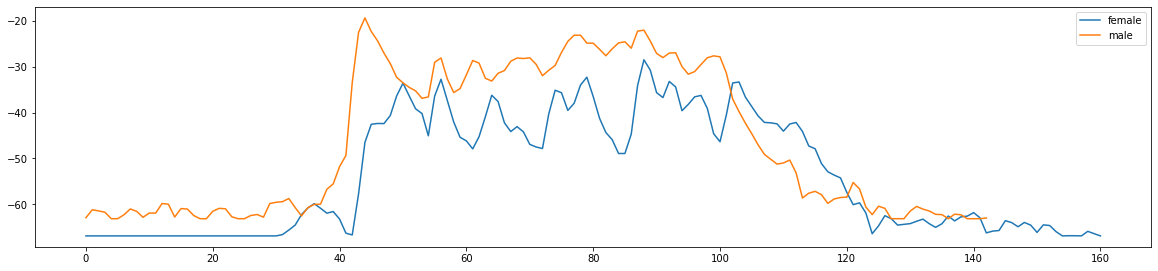

In [ ]:
female = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=12), axis=0)
male = np.mean(librosa.feature.mfcc(y=data_2, sr=sampling_rate_2, n_mfcc=12), axis=0)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

Saving the time series of average values for each sample

In [ ]:
df = pd.DataFrame(columns=['feature'])

i=0
for index, path in enumerate(RAV_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=2.5,
                                  sr=44100, offset=0.5)
    
    sample_rate = np.array(sample_rate)
     
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=12), axis=0)
    df.loc[i] = [mfccs]
    i = i + 1   

print(len(df))
df.head()

672


,feature
0,"[-79.99482, -79.99482, -79.99482, -79.87267, -..."
1,"[-76.64205, -76.64205, -75.91877, -75.01391, -..."
2,"[-79.35955, -79.35955, -79.35955, -79.35955, -..."
3,"[-75.01353, -75.01353, -75.01353, -75.01353, -..."
4,"[-63.607513, -63.70339, -62.941574, -62.27066,..."


Appending these features to a table with the targets and file paths.

In [ ]:
RAV_df_new = pd.concat([RAV_df,pd.DataFrame(df['feature'].values.tolist())], axis=1)
RAV_df_new = RAV_df_new.fillna(0)
RAV_df_new[:5]

,gender,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,male,calm,./Actor_01/03-01-02-02-01-01-01.wav,-79.994820,-79.994820,-79.994820,-79.872673,-79.994820,-79.994820,-79.994820,-79.456085,-78.955116,-79.994820,-79.994820,-79.466385,-71.531372,-69.867599,-69.678040,-67.284721,-66.927864,-65.531235,-68.399330,-77.157127,-73.463257,-76.147820,-78.050995,-78.328468,-79.994820,-77.902473,-75.945869,-71.578331,-68.246376,-65.766090,-67.591576,-70.279518,-71.002586,-73.705276,-72.292061,-70.542664,-68.242897,...,-32.842915,-33.492573,-32.804493,-32.340481,-32.894428,-31.757494,-32.193680,-32.317047,-33.790165,-36.434364,-34.315136,-34.786530,-34.445782,-35.879795,-38.158260,-38.321205,-40.481930,-42.394020,-44.553288,-46.339054,-46.805050,-48.222641,-49.369892,-49.739971,-51.612240,-53.479187,-54.722507,-54.972103,-54.768955,-57.003525,-56.452908,-55.890106,-58.846752,-59.245346,-56.590054,-57.346066,-59.370377,-61.195271,-62.642376,-61.596821
1,male,calm,./Actor_01/03-01-02-02-02-02-01.wav,-76.642052,-76.642052,-75.918770,-75.013908,-76.642052,-76.642052,-76.642052,-76.642052,-76.642052,-76.642052,-76.612877,-75.124344,-69.277443,-69.000504,-70.290802,-65.731041,-59.347107,-57.018375,-61.008144,-63.285660,-60.539165,-58.838867,-58.256226,-62.391598,-63.386967,-61.676270,-64.070610,-66.374397,-68.075073,-71.251595,-72.251831,-70.126762,-67.812027,-69.491142,-64.730034,-63.743717,-64.943993,...,-36.297913,-35.974968,-33.090351,-28.734907,-28.051748,-29.245087,-29.964918,-31.612162,-33.944603,-33.466183,-31.331076,-28.733866,-28.771103,-28.919466,-30.321581,-31.005888,-33.122841,-31.529070,-32.063782,-31.839785,-31.396627,-31.848450,-32.780880,-34.557091,-34.901447,-34.869953,-36.529930,-36.222263,-35.451050,-34.811974,-34.147884,-35.729343,-36.193401,-38.457489,-42.723766,-43.607727,-45.268127,-44.779789,-46.528961,-49.470852
2,male,calm,./Actor_01/03-01-02-02-02-01-01.wav,-79.359550,-79.359550,-79.359550,-79.359550,-74.770355,-75.407898,-79.359550,-79.359550,-79.359550,-79.359550,-79.359550,-79.359550,-79.359550,-77.597389,-77.156364,-79.359550,-79.359550,-79.359550,-79.359550,-79.359550,-79.359550,-79.359550,-78.996681,-78.194916,-77.678947,-78.651627,-74.270592,-71.169655,-72.392471,-72.956551,-71.967415,-68.829369,-67.848259,-68.825356,-72.595589,-73.323021,-67.780510,...,-30.381615,-29.850710,-30.236664,-28.487490,-28.822851,-29.171064,-28.638023,-29.191658,-30.016233,-30.818855,-32.270050,-33.181377,-31.894539,-31.531019,-30.964056,-30.776077,-30.165955,-29.617126,-28.583389,-29.241495,-31.507925,-33.385445,-35.609371,-37.740669,-36.271778,-32.556583,-27.402178,-26.487429,-27.738340,-29.345589,-28.847902,-27.972120,-28.622301,-29.691839,-28.604897,-28.778589,-28.916994,-28.194452,-25.805716,-23.655115
3,male,calm,./Actor_01/03-01-02-02-01-02-01.wav,-75.013527,-75.013527,-75.013527,-75.013527,-74.671074,-73.740089,-73.855171,-73.661362,-70.995056,-72.933113,-75.013527,-75.013527,-75.013527,-75.013527,-74.906929,-74.722809,-75.013527,-75.013527,-75.013527,-75.013527,-75.013527,-75.013527,-75.013527,-75.013527,-75.013527,-73.627800,-70.160866,-72.859383,-73.607117,-75.013527,-75.013527,-74.099136,-74.998772,-73.744606,-74.843941,-72.456902,-67.376030,...,-30.031519,-29.491661,-31.506021,-35.133350,-37.393353,-38.508564,-39.830189,-36.162830,-30.399546,-28.204878,-31.162277,-33.124977,-33.177353,-34.941643,-34.895149,-37.211746,-34.937859,-31.514124,-28.532471,-29.524954,-30.716011,-31.816093,-31.240168,-31.978363,-31.516487,-31.906561,-31.396578,-31.915281,-31.873793,-32.244331,-32.454506,-32.076458,-33.023594,-32.664501,-33.145527,-33.937977,-34.358738,-34.987629,-35.196201,-34.073200
4,male,happy,./Actor_01/03-01-03-02-01-01-01.wav,-63.607513,-63.703388,-62.941574,-62.270660,-63.208023,-64.727592,-64

Defining a function to prepare prepare the data to be inserted into the NN models. 

Data can be normalized, filtered by gender, and divided into training, validation and test sets.

In [ ]:
def PrepareData(df, target="gender", filter_gender=None, norm=True):
    '''
    Receives as input a dataset including 'gender' and 'emotion' target columns, 
    along with the features used to train the models.
    
    target - set the target for the model prediction as either 'gender' or 'emotion'
    
    filter_gender - get 'emotions' as a target filtered by either 'male' or 'female'. Only valid if target="emotion"
    
    '''
    
    if target == "gender" and filter_gender != None:
        raise Exception("filter_gender requires target='emotions'")
    elif target == "emotion" and filter_gender == "male":
        df = df[df['gender'] == "male"]
    elif target == "emotion" and filter_gender == "female":
        df = df[df['gender'] == "female"]

    X = df.drop(['path','gender','emotion'],axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

    if norm == True:
    # Normalization
      mean = np.mean(X_train, axis=0)
      std = np.std(X_train, axis=0)

      X_train = (X_train - mean)/std
      X_val = (X_val - mean)/std
      X_test = (X_test - mean)/std

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # encode the target 
    lb = LabelEncoder()
    y_train = np_utils.to_categorical(lb.fit_transform(y_train))
    y_val = np_utils.to_categorical(lb.fit_transform(y_val))
    y_test = np_utils.to_categorical(lb.fit_transform(y_test))

    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, lb

# 1D CNN

## Gender classification

### Without normalization, batch normalization and dropout

Creating the first 1D CNN model, without any optimizations.

In [ ]:
def MakeFirstModel(optimizer="RMS"):
# New model
    model = Sequential()
    model.add(Conv1D(256, 8, padding='same', activation='relu', input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
    model.add(Conv1D(256, 8, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=(8)))

    model.add(Conv1D(128, 8, padding='same', activation='relu'))
    model.add(Conv1D(128, 8, padding='same', activation='relu'))
    model.add(Conv1D(128, 8, padding='same', activation='relu'))
    model.add(Conv1D(128, 8, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=(8)))

    model.add(Conv1D(64, 8, padding='same', activation='relu'))
    model.add(Conv1D(64, 8, padding='same', activation='relu'))

    model.add(Flatten())
    model.add(Dense(2, activation='softmax')) # Target class number

    
    if optimizer == "SGD":
        opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
    elif optimizer == "Adam":
        opt = keras.optimizers.Adam(lr=0.0001)
    elif optimizer == "RMS":
        opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
        
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

Geting the training, validation and test datasets, as well as the decoder for the encoded targets.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, lb = PrepareData(RAV_df_new, target="gender", norm=False)

In [ ]:
model_raw = MakeFirstModel()
model_raw.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 216, 256)          2304      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 216, 256)          524544    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 27, 256)           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 27, 128)           262272    
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 27, 128)           131200    
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 27, 128)           131200    
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 27, 128)          

Getting a schema representation of the network's architecture.

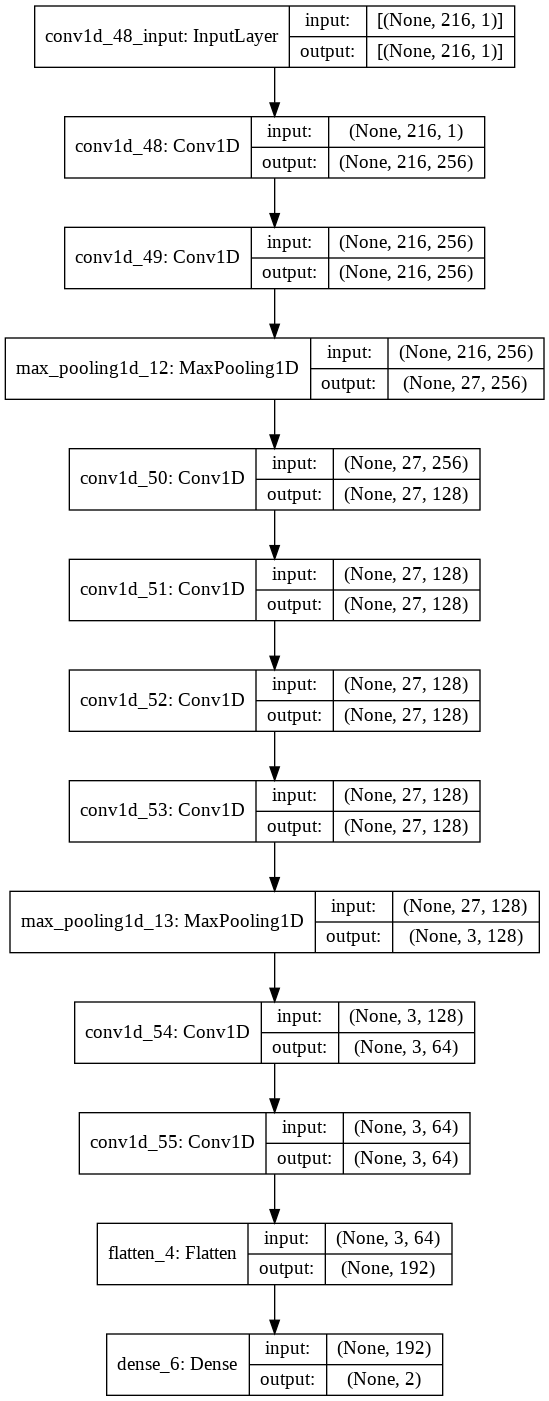

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_raw, to_file='/content/models/model_raw_plot.png', show_shapes=True, show_layer_names=True)

Training the model on the training data with a batch size of 16 for 150 epochs.

In [ ]:
model_raw_history = model_raw.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
30/30 [==============================] - 2s 21ms/step - loss: 0.6813 - accuracy: 0.5282 - val_loss: 0.6332 - val_accuracy: 0.7921
Epoch 2/150
30/30 [==============================] - 0s 11ms/step - loss: 0.6200 - accuracy: 0.8154 - val_loss: 0.5711 - val_accuracy: 0.8614
Epoch 3/150
30/30 [==============================] - 0s 11ms/step - loss: 0.5744 - accuracy: 0.7922 - val_loss: 0.5252 - val_accuracy: 0.8812
Epoch 4/150
30/30 [==============================] - 0s 12ms/step - loss: 0.5314 - accuracy: 0.8195 - val_loss: 0.4811 - val_accuracy: 0.8812
Epoch 5/150
30/30 [==============================] - 0s 11ms/step - loss: 0.4910 - accuracy: 0.8472 - val_loss: 0.4343 - val_accuracy: 0.8713
Epoch 6/150
30/30 [==============================] - 0s 11ms/step - loss: 0.4341 - accuracy: 0.8324 - val_loss: 0.4131 - val_accuracy: 0.8515
Epoch 7/150
30/30 [==============================] - 0s 11ms/step - loss: 0.4091 - accuracy: 0.8459 - val_loss: 0.3797 - val_accuracy: 0.8911
Epoch 

Defining functions to plot the Loss and Accuracy over training epochs of the models.

In [ ]:
def PlotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [ ]:
def PlotAcc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

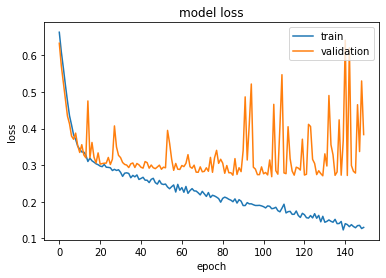

In [ ]:
PlotLoss(model_raw_history)

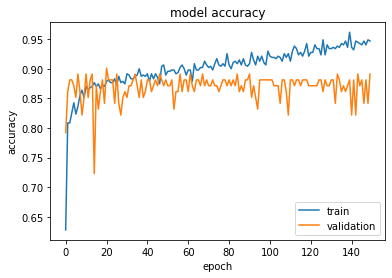

In [ ]:
PlotAcc(model_raw_history)

Checking the models performance on training data.

In [ ]:
metrics = model_raw.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 0.365 
Accuracy: 0.881


Defining a function to get the labels of the predictions on the test data.

In [ ]:
def GetPredictions(model, X_test, y_test, lb):

    preds = model.predict(X_test, 
                          batch_size=16, 
                          verbose=1)

    preds = preds.argmax(axis=1)

    # predictions 
    preds = preds.astype(int).flatten()
    preds = (lb.inverse_transform((preds)))
    preds = pd.DataFrame({'predictedvalues': preds})

    # Actual labels
    actual = y_test.argmax(axis=1)
    actual = actual.astype(int).flatten()
    actual = (lb.inverse_transform((actual)))
    actual = pd.DataFrame({'actualvalues': actual})

    # Lets combine both of them into a single dataframe
    pred_df = actual.join(preds)
    return pred_df

In [ ]:
model_raw_pred = GetPredictions(model_raw, X_test, y_test, lb)

7/7 [==============================] - 0s 5ms/step


Defining a function to display the confusion matrix of predicted vs actual labels.

In [ ]:
# the confusion matrix heat map plot
def print_confusion_matrix(prediction_df, pred="gender", figsize = (10,7), fontsize=14):
    
    if pred == "gender":
        class_names = ["male","female"]
    elif pred == "emotion":
        class_names = ["calm","angry","sad","fear","happy","surprise","disgust"]

    c_matrix = confusion_matrix(prediction_df.actualvalues, prediction_df.predictedvalues)

    df_cm = pd.DataFrame(
        c_matrix, index = class_names, columns = class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

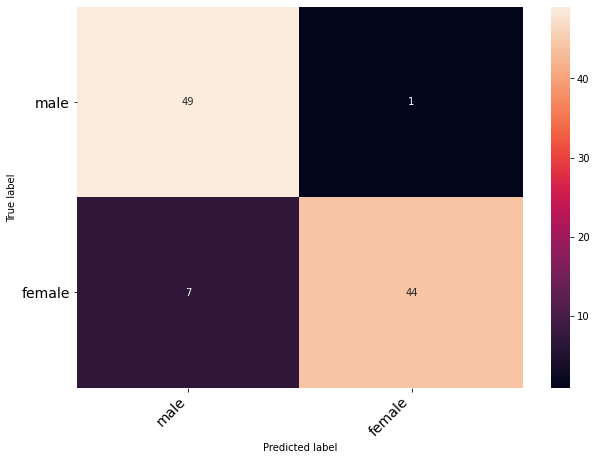

In [ ]:
print_confusion_matrix(model_raw_pred)

### Without early stopping

Defining an improved model with Batch normalization and Dropout.

In [ ]:
def MakeNewModel(optimizer="RMS", target_num=2):
# New model
    model = Sequential()
    model.add(Conv1D(256, 8, padding='same', activation='relu', input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
    model.add(Conv1D(256, 8, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 8, padding='same', activation='relu'))
    model.add(Conv1D(128, 8, padding='same', activation='relu'))
    model.add(Conv1D(128, 8, padding='same', activation='relu'))
    model.add(Conv1D(128, 8, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(64, 8, padding='same', activation='relu'))
    model.add(Conv1D(64, 8, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(target_num, activation='softmax')) # Target class number
    
    if optimizer == "SGD":
        opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
    elif optimizer == "Adam":
        opt = keras.optimizers.Adam(lr=0.0001)
    elif optimizer == "RMS":
        opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
        
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

Geting the training, validation and test datasets, as well as the decoder for the encoded targets.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, lb = PrepareData(RAV_df_new, target="gender")

In [ ]:
model_gender = MakeNewModel()
model_gender.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 216, 256)          2304      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 27, 256)           0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 27, 128)           262272    
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 27, 128)          

Getting a schema representation of the network's architecture.


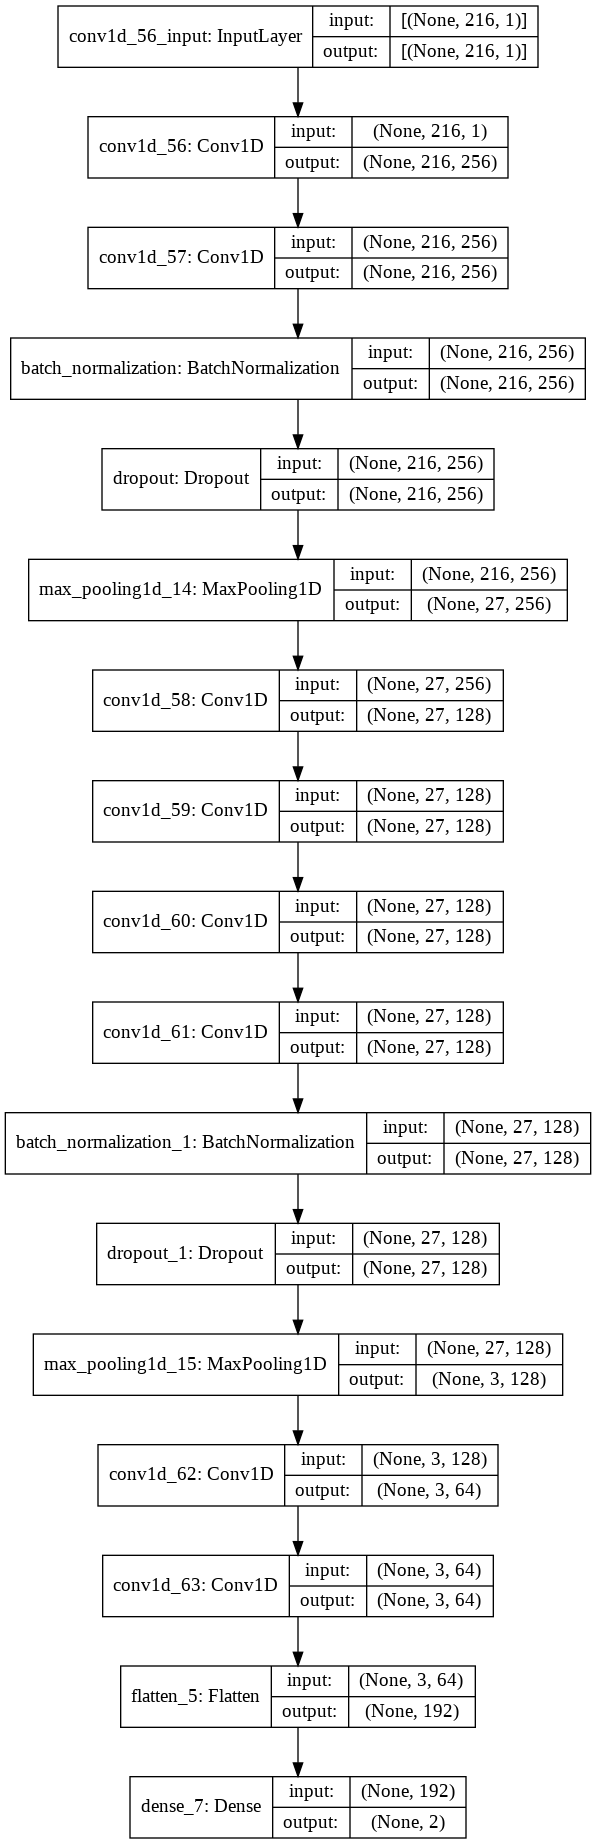

In [ ]:
plot_model(model_gender, to_file='/content/models/model_gender_plot.png', show_shapes=True, show_layer_names=True)

Fitting the training data.

In [ ]:
model_gender_history = model_gender.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
30/30 [==============================] - 33s 57ms/step - loss: 0.6188 - accuracy: 0.6325 - val_loss: 0.6913 - val_accuracy: 0.5050
Epoch 2/150
30/30 [==============================] - 1s 26ms/step - loss: 0.5038 - accuracy: 0.7572 - val_loss: 0.6902 - val_accuracy: 0.5050
Epoch 3/150
30/30 [==============================] - 1s 26ms/step - loss: 0.4115 - accuracy: 0.8407 - val_loss: 0.6892 - val_accuracy: 0.5050
Epoch 4/150
30/30 [==============================] - 1s 26ms/step - loss: 0.3645 - accuracy: 0.8519 - val_loss: 0.6874 - val_accuracy: 0.5050
Epoch 5/150
30/30 [==============================] - 1s 26ms/step - loss: 0.3412 - accuracy: 0.8711 - val_loss: 0.6848 - val_accuracy: 0.5050
Epoch 6/150
30/30 [==============================] - 1s 26ms/step - loss: 0.3034 - accuracy: 0.8840 - val_loss: 0.6814 - val_accuracy: 0.5050
Epoch 7/150
30/30 [==============================] - 1s 25ms/step - loss: 0.3276 - accuracy: 0.8821 - val_loss: 0.6759 - val_accuracy: 0.5941
Epoch

Visualizing loss and accuracy over training epochs.

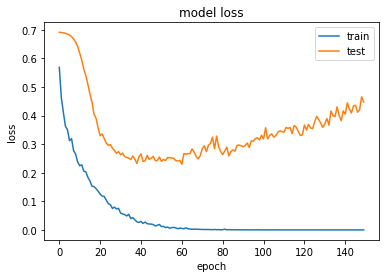

In [ ]:
PlotLoss(model_gender_history)

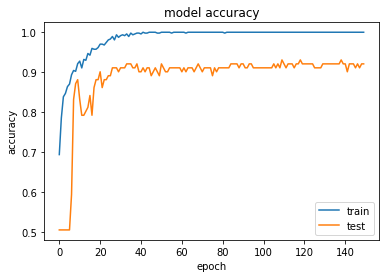

In [ ]:
PlotAcc(model_gender_history)

In [ ]:
metrics = model_gender.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 0.427 
Accuracy: 0.911


### With early stopping

Even though we were able to achieve a relatively high accuracy score, we can see that our model is overfitting. We will try this to mitigate this overfitting by adding an early stop to the training.

In [ ]:
model_gender_stop = MakeNewModel()

Fitting the model with early stopping.

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=20)

model_gender_stop_history = model_gender_stop.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/150
30/30 [==============================] - 3s 37ms/step - loss: 0.6641 - accuracy: 0.5890 - val_loss: 0.6927 - val_accuracy: 0.4950
Epoch 2/150
30/30 [==============================] - 1s 26ms/step - loss: 0.4696 - accuracy: 0.8348 - val_loss: 0.6919 - val_accuracy: 0.7525
Epoch 3/150
30/30 [==============================] - 1s 26ms/step - loss: 0.4057 - accuracy: 0.8511 - val_loss: 0.6905 - val_accuracy: 0.8416
Epoch 4/150
30/30 [==============================] - 1s 26ms/step - loss: 0.3813 - accuracy: 0.8487 - val_loss: 0.6882 - val_accuracy: 0.8119
Epoch 5/150
30/30 [==============================] - 1s 26ms/step - loss: 0.3425 - accuracy: 0.8805 - val_loss: 0.6857 - val_accuracy: 0.8218
Epoch 6/150
30/30 [==============================] - 1s 26ms/step - loss: 0.3035 - accuracy: 0.8918 - val_loss: 0.6818 - val_accuracy: 0.8515
Epoch 7/150
30/30 [==============================] - 1s 26ms/step - loss: 0.2974 - accuracy: 0.8915 - val_loss: 0.6772 - val_accuracy: 0.8713
Epoch 

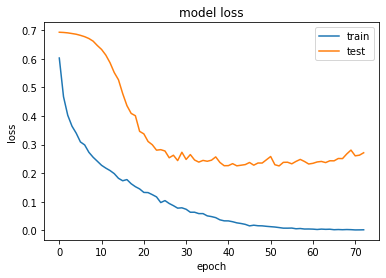

In [ ]:
PlotLoss(model_gender_stop_history)

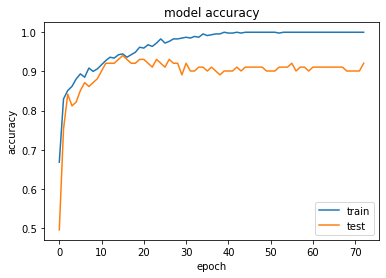

In [ ]:
PlotAcc(model_gender_stop_history)

In [ ]:
metrics = model_gender_stop.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 0.257 
Accuracy: 0.931


In [ ]:
gender_stop_pred = GetPredictions(model_gender_stop, X_test, y_test, lb)

7/7 [==============================] - 0s 7ms/step


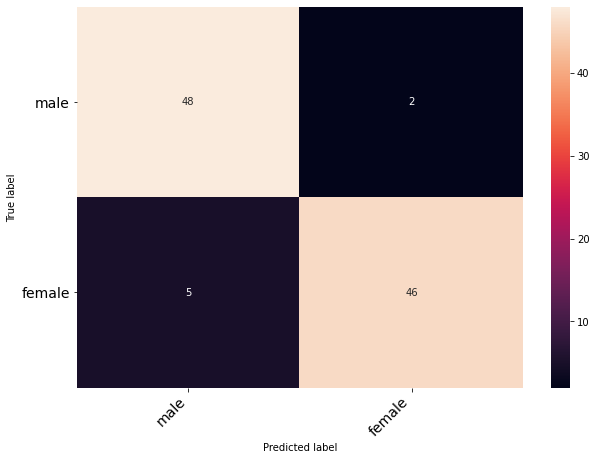

In [ ]:
print_confusion_matrix(gender_stop_pred)

## Emotion classification

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, lb = PrepareData(RAV_df_new, target="emotion")

In [ ]:
model_emotion = MakeNewModel(target_num=7)

In [ ]:
model_history_emotion = model_emotion.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
30/30 [==============================] - 3s 41ms/step - loss: 1.9390 - accuracy: 0.1778 - val_loss: 1.9459 - val_accuracy: 0.1485
Epoch 2/150
30/30 [==============================] - 1s 26ms/step - loss: 1.8388 - accuracy: 0.3042 - val_loss: 1.9460 - val_accuracy: 0.1485
Epoch 3/150
30/30 [==============================] - 1s 26ms/step - loss: 1.7699 - accuracy: 0.3342 - val_loss: 1.9458 - val_accuracy: 0.1485
Epoch 4/150
30/30 [==============================] - 1s 26ms/step - loss: 1.7124 - accuracy: 0.3449 - val_loss: 1.9457 - val_accuracy: 0.1485
Epoch 5/150
30/30 [==============================] - 1s 26ms/step - loss: 1.6941 - accuracy: 0.4031 - val_loss: 1.9455 - val_accuracy: 0.1485
Epoch 6/150
30/30 [==============================] - 1s 25ms/step - loss: 1.6322 - accuracy: 0.4341 - val_loss: 1.9453 - val_accuracy: 0.1485
Epoch 7/150
30/30 [==============================] - 1s 25ms/step - loss: 1.6428 - accuracy: 0.4281 - val_loss: 1.9441 - val_accuracy: 0.1485
Epoch 

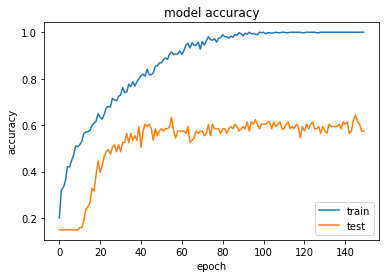

In [ ]:
PlotAcc(model_history_emotion)

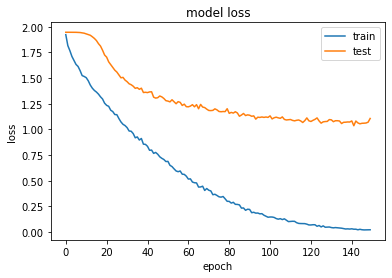

In [ ]:
PlotLoss(model_history_emotion)

In [ ]:
metrics = model_emotion.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 1.217 
Accuracy: 0.554


In [ ]:
emotion_preds = GetPredictions(model_emotion, X_test, y_test, lb)

7/7 [==============================] - 0s 7ms/step


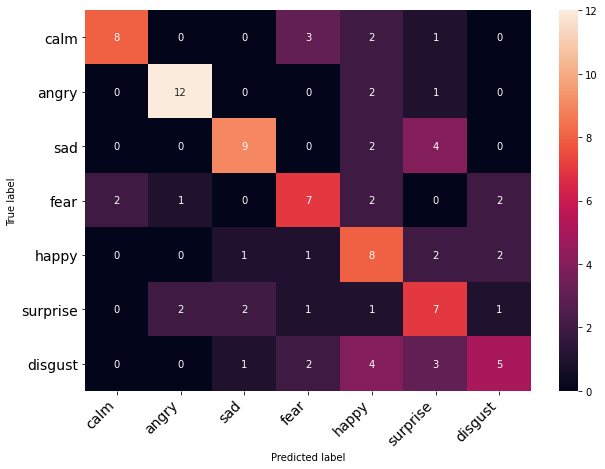

In [ ]:
print_confusion_matrix(emotion_preds, pred="emotion")

## Emotion classification by gender

### Male

Geting the training, validation and test datasets, as well as the decoder for the encoded targets.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, lb = PrepareData(RAV_df_new, target="emotion", filter_gender="male")

In [ ]:
model_emotion_male = MakeNewModel(target_num=7)

In [ ]:
model_emotion_male_history = model_emotion_male.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
15/15 [==============================] - 3s 87ms/step - loss: 2.0616 - accuracy: 0.1608 - val_loss: 1.9451 - val_accuracy: 0.1176
Epoch 2/150
15/15 [==============================] - 0s 27ms/step - loss: 1.9469 - accuracy: 0.1645 - val_loss: 1.9450 - val_accuracy: 0.1569
Epoch 3/150
15/15 [==============================] - 0s 27ms/step - loss: 1.8414 - accuracy: 0.2838 - val_loss: 1.9448 - val_accuracy: 0.1569
Epoch 4/150
15/15 [==============================] - 0s 27ms/step - loss: 1.7977 - accuracy: 0.3014 - val_loss: 1.9444 - val_accuracy: 0.1569
Epoch 5/150
15/15 [==============================] - 0s 27ms/step - loss: 1.7613 - accuracy: 0.3520 - val_loss: 1.9440 - val_accuracy: 0.1569
Epoch 6/150
15/15 [==============================] - 0s 27ms/step - loss: 1.7195 - accuracy: 0.3831 - val_loss: 1.9438 - val_accuracy: 0.1569
Epoch 7/150
15/15 [==============================] - 0s 28ms/step - loss: 1.6854 - accuracy: 0.3924 - val_loss: 1.9439 - val_accuracy: 0.1569
Epoch 

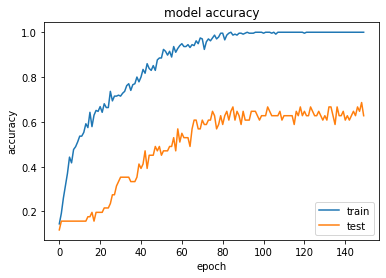

In [ ]:
PlotAcc(model_emotion_male_history)

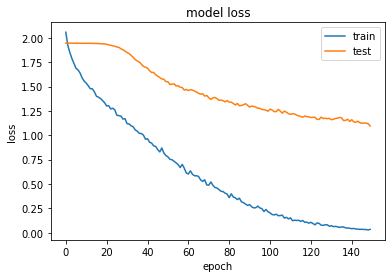

In [ ]:
PlotLoss(model_emotion_male_history)

In [ ]:
metrics = model_emotion_male.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 1.326 
Accuracy: 0.44


In [ ]:
emotion_male_preds = GetPredictions(model_emotion_male, X_test, y_test, lb)

4/4 [==============================] - 0s 7ms/step


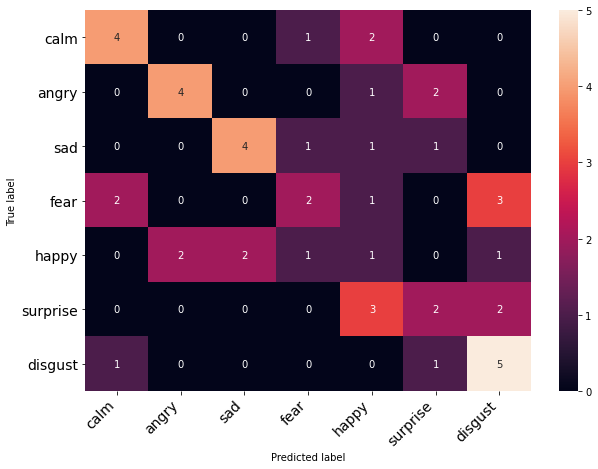

In [ ]:
print_confusion_matrix(emotion_male_preds, pred="emotion")

### Female

Geting the training, validation and test datasets, as well as the decoder for the encoded targets.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, lb = PrepareData(RAV_df_new, target="emotion", filter_gender="female")

In [ ]:
model_emotion_female = MakeNewModel(target_num=7)

In [ ]:
model_emotion_female_history = model_emotion_female.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
15/15 [==============================] - 3s 49ms/step - loss: 1.9923 - accuracy: 0.0908 - val_loss: 1.9450 - val_accuracy: 0.1765
Epoch 2/150
15/15 [==============================] - 0s 27ms/step - loss: 1.8743 - accuracy: 0.2395 - val_loss: 1.9446 - val_accuracy: 0.1569
Epoch 3/150
15/15 [==============================] - 0s 27ms/step - loss: 1.8222 - accuracy: 0.3432 - val_loss: 1.9443 - val_accuracy: 0.1569
Epoch 4/150
15/15 [==============================] - 0s 27ms/step - loss: 1.7734 - accuracy: 0.3942 - val_loss: 1.9440 - val_accuracy: 0.1569
Epoch 5/150
15/15 [==============================] - 0s 27ms/step - loss: 1.6987 - accuracy: 0.4950 - val_loss: 1.9437 - val_accuracy: 0.1569
Epoch 6/150
15/15 [==============================] - 0s 28ms/step - loss: 1.6470 - accuracy: 0.5293 - val_loss: 1.9434 - val_accuracy: 0.1569
Epoch 7/150
15/15 [==============================] - 0s 28ms/step - loss: 1.6295 - accuracy: 0.5934 - val_loss: 1.9430 - val_accuracy: 0.1569
Epoch 

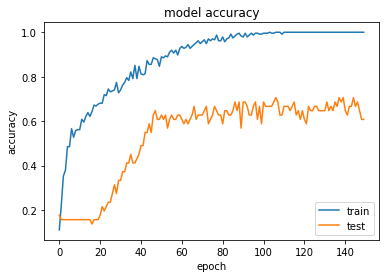

In [ ]:
PlotAcc(model_emotion_female_history)

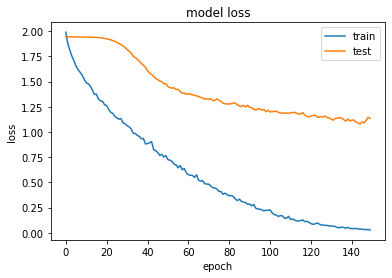

In [ ]:
PlotLoss(model_emotion_female_history)

In [ ]:
metrics = model_emotion_female.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 1.112 
Accuracy: 0.6


In [ ]:
emotion_female_preds = GetPredictions(model_emotion_female, X_test, y_test, lb)

4/4 [==============================] - 0s 8ms/step


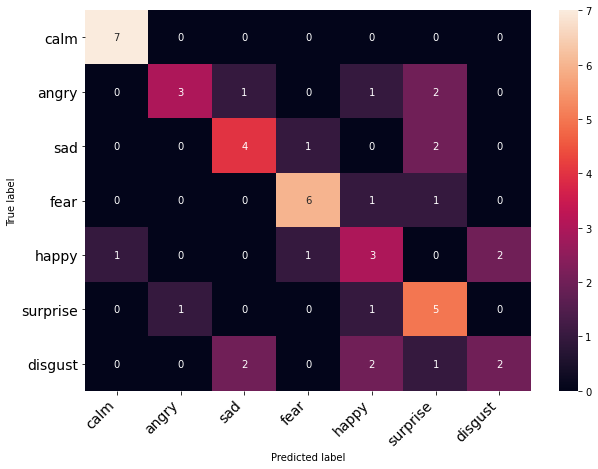

In [ ]:
print_confusion_matrix(emotion_female_preds, pred="emotion")

# 2D CNN

Defining a function to prepare data with higher dimensionality for input on the 2D CNN model.

In [ ]:
from tqdm import tqdm, tqdm_pandas

def PrepareData2D(df, n_mfcc=12, target="gender", filter_gender=None):
    
    if target == "gender" and filter_gender != None:
        raise Exception("filter_gender requires target='emotions'")
    elif target == "emotion" and filter_gender == "male":
        df = df[df['gender'] == "male"]
    elif target == "emotion" and filter_gender == "female":
        df = df[df['gender'] == "female"]
    
    sampling_rate=44100
    audio_duration=2.5
    
    X = np.empty(shape=(df.shape[0], n_mfcc, 216, 1))
    input_length = sampling_rate * audio_duration
    y = df[target]
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=audio_duration
                               ,offset=0.5)

        # MFCC extraction 
        MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
        MFCC = np.expand_dims(MFCC, axis=-1)
        X[cnt,] = MFCC
        cnt += 1
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

    # one hot encode the target 
    lb = LabelEncoder()
    y_train = np_utils.to_categorical(lb.fit_transform(y_train))
    y_val = np_utils.to_categorical(lb.fit_transform(y_val))
    y_test = np_utils.to_categorical(lb.fit_transform(y_test))

    # Normalization as per the standard NN process
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train = (X_train - mean)/std
    X_val = (X_val - mean)/std
    X_test = (X_test - mean)/std
    
    return X_train, X_val, X_test, y_train, y_val, y_test, lb

Defining the architecture for the 2D CNN based on the best performing network from the 1D implementation.

In [ ]:
def MakeNewModel(optimizer="RMS", target_num=2):
# New model
    model = Sequential()
    model.add(Convolution2D(128, 8, padding='same', activation='relu', input_shape=(12,216,1)))  # X_train.shape[1] = No. of Columns
    model.add(Convolution2D(128, 8, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(MaxPooling2D())
    model.add(Convolution2D(64, 8, padding='same', activation='relu'))
    model.add(Convolution2D(64, 8, padding='same', activation='relu'))
    model.add(Convolution2D(64, 8, padding='same', activation='relu'))
    model.add(Convolution2D(64, 8, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(MaxPooling2D())
    model.add(Convolution2D(32, 8, padding='same', activation='relu'))
    model.add(Convolution2D(32, 8, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(target_num, activation='softmax')) # Target class number
    
    if optimizer == "SGD":
        opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
    elif optimizer == "Adam":
        opt = keras.optimizers.Adam(lr=0.0001)
    elif optimizer == "RMS":
        opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
        
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

## Gender classification

Geting the training, validation and test datasets, as well as the decoder for the encoded targets.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, lb = PrepareData2D(RAV_df_new, target="gender")

100%|██████████| 672/672 [00:46<00:00, 14.56it/s]


In [ ]:
model_2d_gender = MakeNewModel(target_num=2)
model_2d_gender.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 12, 216, 128)      8320      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 216, 128)      1048704   
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 216, 128)      512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 216, 128)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 108, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 108, 64)        524352    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 108, 64)      

Getting a schema representation of the network's architecture.


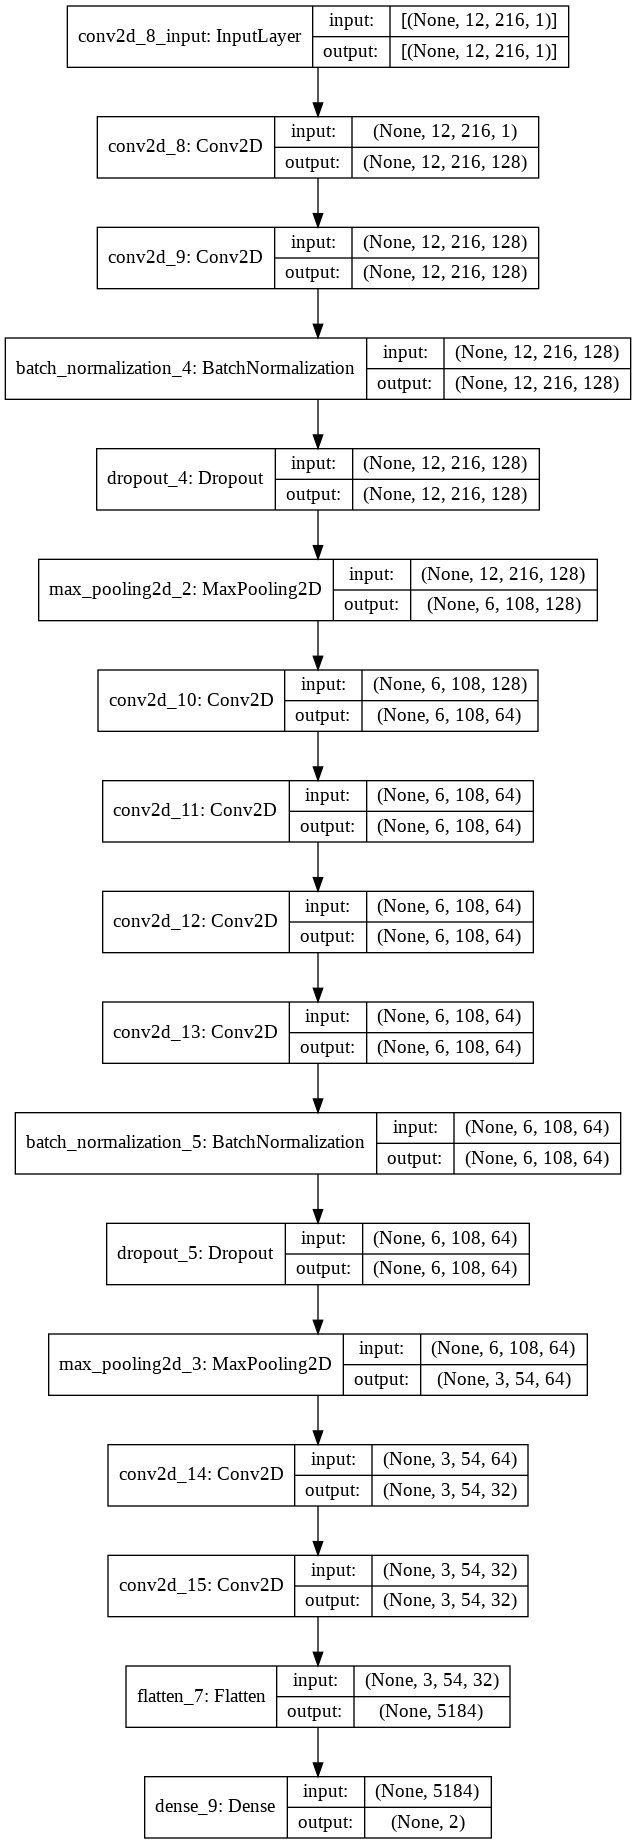

In [ ]:
plot_model(model_2d_gender, to_file='/content/models/model_2d_gender_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_2d_gender_history = model_2d_gender.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
30/30 [==============================] - 8s 212ms/step - loss: 0.6325 - accuracy: 0.6692 - val_loss: 0.6912 - val_accuracy: 0.5149
Epoch 2/150
30/30 [==============================] - 6s 203ms/step - loss: 0.4116 - accuracy: 0.8578 - val_loss: 0.6896 - val_accuracy: 0.4950
Epoch 3/150
30/30 [==============================] - 6s 202ms/step - loss: 0.2988 - accuracy: 0.9315 - val_loss: 0.6871 - val_accuracy: 0.4950
Epoch 4/150
30/30 [==============================] - 6s 201ms/step - loss: 0.1976 - accuracy: 0.9538 - val_loss: 0.6789 - val_accuracy: 0.4950
Epoch 5/150
30/30 [==============================] - 6s 202ms/step - loss: 0.1239 - accuracy: 0.9656 - val_loss: 0.6727 - val_accuracy: 0.4950
Epoch 6/150
30/30 [==============================] - 6s 201ms/step - loss: 0.0635 - accuracy: 0.9859 - val_loss: 0.6556 - val_accuracy: 0.4950
Epoch 7/150
30/30 [==============================] - 6s 201ms/step - loss: 0.0506 - accuracy: 0.9925 - val_loss: 0.6375 - val_accuracy: 0.5149

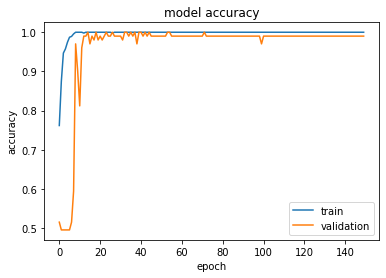

In [ ]:
PlotAcc(model_2d_gender_history)

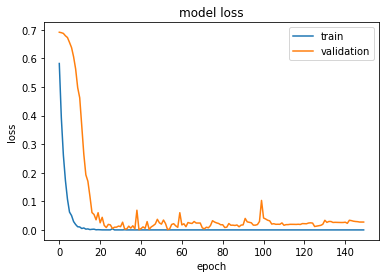

In [ ]:
PlotLoss(model_2d_gender_history)

In [ ]:
metrics = model_2d_gender.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 0.001 
Accuracy: 1.0


In [ ]:
gender_2d_preds = GetPredictions(model_2d_gender, X_test, y_test, lb)

7/7 [==============================] - 0s 50ms/step


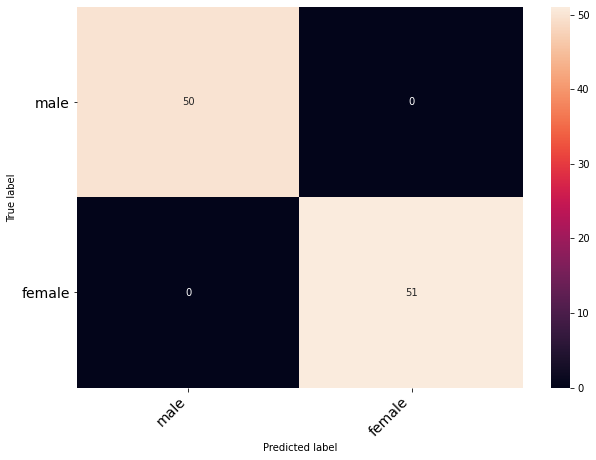

In [ ]:
print_confusion_matrix(gender_2d_preds, pred="gender")

## Emotion classification

Geting the training, validation and test datasets, as well as the decoder for the encoded targets.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, lb = PrepareData2D(RAV_df_new, target="emotion")

100%|██████████| 672/672 [00:45<00:00, 14.73it/s]


In [ ]:
model_2d = MakeNewModel(target_num=7)

In [ ]:
model_2d_emotion_history = model_2d.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
30/30 [==============================] - 10s 248ms/step - loss: 1.9444 - accuracy: 0.1786 - val_loss: 1.9454 - val_accuracy: 0.2475
Epoch 2/150
30/30 [==============================] - 6s 201ms/step - loss: 1.7437 - accuracy: 0.3932 - val_loss: 1.9445 - val_accuracy: 0.2376
Epoch 3/150
30/30 [==============================] - 6s 201ms/step - loss: 1.5951 - accuracy: 0.5484 - val_loss: 1.9427 - val_accuracy: 0.2376
Epoch 4/150
30/30 [==============================] - 6s 201ms/step - loss: 1.4392 - accuracy: 0.6079 - val_loss: 1.9396 - val_accuracy: 0.2376
Epoch 5/150
30/30 [==============================] - 6s 202ms/step - loss: 1.2996 - accuracy: 0.6598 - val_loss: 1.9344 - val_accuracy: 0.2475
Epoch 6/150
30/30 [==============================] - 6s 201ms/step - loss: 1.1623 - accuracy: 0.7367 - val_loss: 1.9274 - val_accuracy: 0.2673
Epoch 7/150
30/30 [==============================] - 6s 201ms/step - loss: 1.0352 - accuracy: 0.7789 - val_loss: 1.9147 - val_accuracy: 0.277

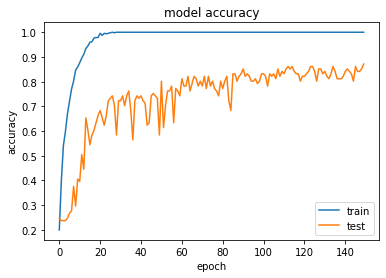

In [ ]:
PlotAcc(model_2d_emotion_history)

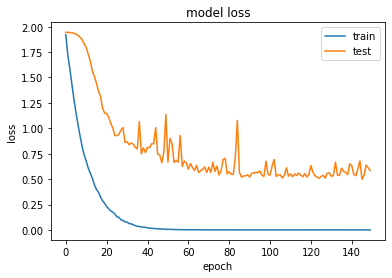

In [ ]:
PlotLoss(model_2d_emotion_history)

In [ ]:
metrics = model_2d.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 1.108 
Accuracy: 0.762


In [ ]:
emotion_2d_preds = GetPredictions(model_2d, X_test, y_test, lb)

7/7 [==============================] - 0s 60ms/step


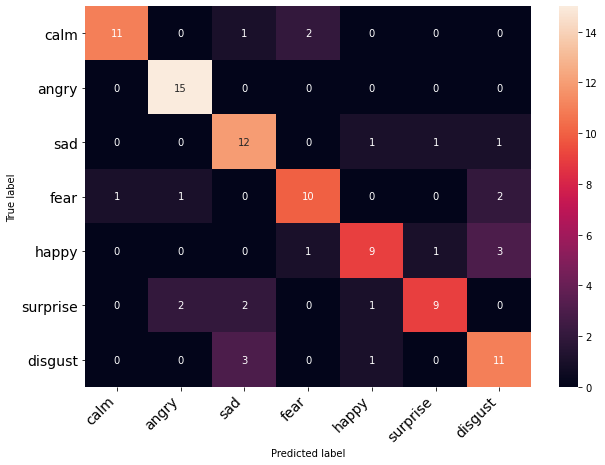

In [ ]:
print_confusion_matrix(emotion_2d_preds, pred="emotion")

## Emotion classification by gender

### Male

Geting the training, validation and test datasets, as well as the decoder for the encoded targets.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, lb = PrepareData2D(RAV_df_new, target="emotion", filter_gender="male")

100%|██████████| 336/336 [00:22<00:00, 14.97it/s]


In [ ]:
model_2d_male = MakeNewModel(target_num=7)

In [ ]:
model_2d_male_emotion_history = model_2d_male.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
15/15 [==============================] - 5s 221ms/step - loss: 2.0231 - accuracy: 0.1926 - val_loss: 1.9453 - val_accuracy: 0.1961
Epoch 2/150
15/15 [==============================] - 3s 203ms/step - loss: 1.8052 - accuracy: 0.3506 - val_loss: 1.9455 - val_accuracy: 0.1373
Epoch 3/150
15/15 [==============================] - 3s 205ms/step - loss: 1.7080 - accuracy: 0.5116 - val_loss: 1.9457 - val_accuracy: 0.1373
Epoch 4/150
15/15 [==============================] - 3s 204ms/step - loss: 1.6026 - accuracy: 0.6064 - val_loss: 1.9454 - val_accuracy: 0.1176
Epoch 5/150
15/15 [==============================] - 3s 204ms/step - loss: 1.5237 - accuracy: 0.6788 - val_loss: 1.9449 - val_accuracy: 0.1176
Epoch 6/150
15/15 [==============================] - 3s 203ms/step - loss: 1.4255 - accuracy: 0.7429 - val_loss: 1.9444 - val_accuracy: 0.1176
Epoch 7/150
15/15 [==============================] - 3s 203ms/step - loss: 1.3133 - accuracy: 0.7494 - val_loss: 1.9441 - val_accuracy: 0.1176

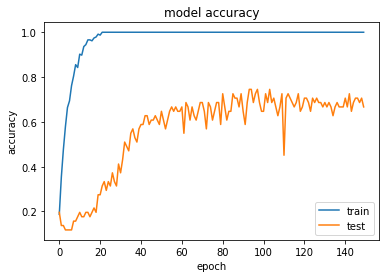

In [ ]:
PlotAcc(model_2d_male_emotion_history)

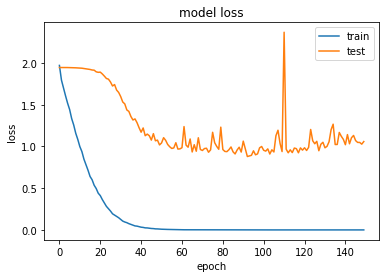

In [ ]:
PlotLoss(model_2d_male_emotion_history)

In [ ]:
metrics = model_2d.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 0.192 
Accuracy: 0.94


In [ ]:
emotion_2d_preds = GetPredictions(model_2d, X_test, y_test, lb)

4/4 [==============================] - 0s 62ms/step


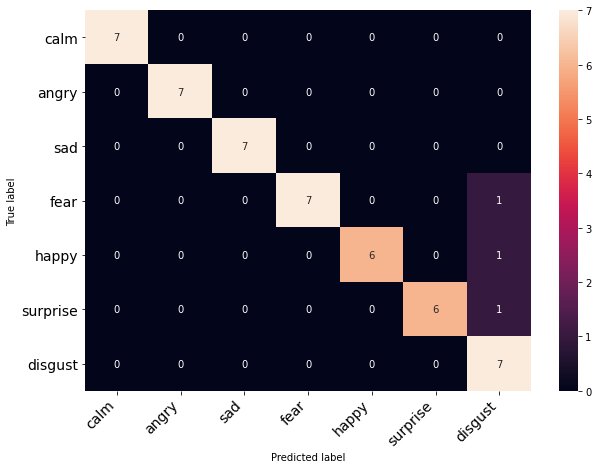

In [ ]:
print_confusion_matrix(emotion_2d_preds, pred="emotion")

### Female

Geting the training, validation and test datasets, as well as the decoder for the encoded targets.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, lb = PrepareData2D(RAV_df_new, target="emotion", filter_gender="female")

100%|██████████| 336/336 [00:22<00:00, 15.17it/s]


In [ ]:
model_2d_female = MakeNewModel(target_num=7)

In [ ]:
model_2d_female_emotion_history = model_2d_female.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_val, y_val))

Epoch 1/150
15/15 [==============================] - 5s 224ms/step - loss: 1.9908 - accuracy: 0.1597 - val_loss: 1.9453 - val_accuracy: 0.2157
Epoch 2/150
15/15 [==============================] - 3s 204ms/step - loss: 1.7703 - accuracy: 0.3767 - val_loss: 1.9448 - val_accuracy: 0.1961
Epoch 3/150
15/15 [==============================] - 3s 203ms/step - loss: 1.6504 - accuracy: 0.5455 - val_loss: 1.9440 - val_accuracy: 0.1569
Epoch 4/150
15/15 [==============================] - 3s 204ms/step - loss: 1.5118 - accuracy: 0.6677 - val_loss: 1.9429 - val_accuracy: 0.1569
Epoch 5/150
15/15 [==============================] - 3s 204ms/step - loss: 1.4086 - accuracy: 0.7334 - val_loss: 1.9413 - val_accuracy: 0.1765
Epoch 6/150
15/15 [==============================] - 3s 204ms/step - loss: 1.2704 - accuracy: 0.7228 - val_loss: 1.9396 - val_accuracy: 0.1569
Epoch 7/150
15/15 [==============================] - 3s 203ms/step - loss: 1.1911 - accuracy: 0.8242 - val_loss: 1.9369 - val_accuracy: 0.1569

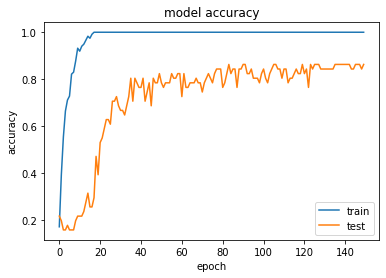

In [ ]:
PlotAcc(model_2d_female_emotion_history)

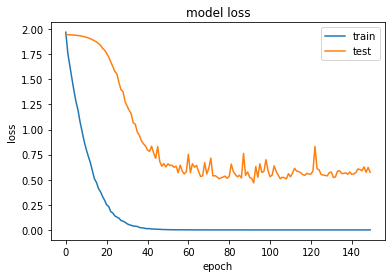

In [ ]:
PlotLoss(model_2d_female_emotion_history)

In [ ]:
metrics = model_2d_female.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 0.595 
Accuracy: 0.88


In [ ]:
emotion_female_2d_preds = GetPredictions(model_2d_female, X_test, y_test, lb)

4/4 [==============================] - 0s 47ms/step


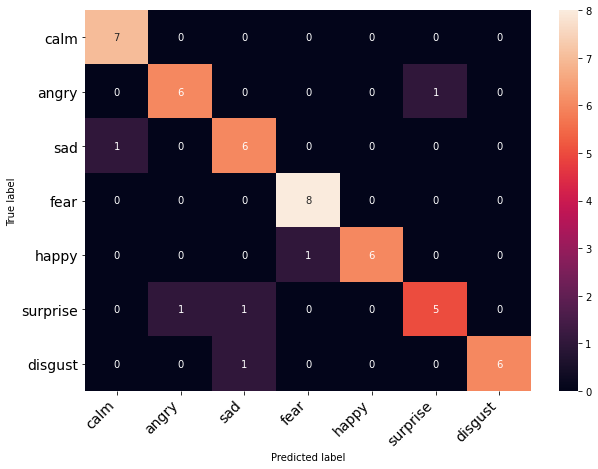

In [ ]:
print_confusion_matrix(emotion_female_2d_preds, pred="emotion")

# RNN (LSTM)

Defining a function to prepared the data for usage on the RNN model.

In [ ]:
def PrepareDataRNN(df, n_mfcc=12, target="gender", filter_gender=None):
    
    if target == "gender" and filter_gender != None:
        raise Exception("filter_gender requires target='emotions'")
    elif target == "emotion" and filter_gender == "male":
        df = df[df['gender'] == "male"]
    elif target == "emotion" and filter_gender == "female":
        df = df[df['gender'] == "female"]
    
    sampling_rate=44100
    audio_duration=2.5
    
    X = np.empty(shape=(df.shape[0], n_mfcc, 216))
    input_length = sampling_rate * audio_duration
    y = df[target]
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=audio_duration
                               ,offset=0.5)

        # MFCC extraction 
        MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
        X[cnt,] = MFCC
        cnt += 1
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

    # one hot encode the target 
    lb = LabelEncoder()
    y_train = np_utils.to_categorical(lb.fit_transform(y_train))
    y_val = np_utils.to_categorical(lb.fit_transform(y_val))
    y_test = np_utils.to_categorical(lb.fit_transform(y_test))

    # Normalization as per the standard NN process
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train = (X_train - mean)/std
    X_val = (X_val - mean)/std
    X_test = (X_test - mean)/std
    
    return X_train, X_val, X_test, y_train, y_val, y_test, lb

Geting the training, validation and test datasets, as well as the decoder for the encoded targets.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, lb = PrepareDataRNN(RAV_df_new, target="emotion")

100%|██████████| 672/672 [00:48<00:00, 13.93it/s]


Defining the RNN model.

In [ ]:
from keras.layers import LSTM

def MakeRNNModel(optimizer="RMS", target_num=2):

    LSTM_UNITS = 128
    DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

    # New model
    model = Sequential()

    model.add(LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))  # X_train.shape[1] = No. of Columns
    model.add(LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

    model.add(Dense(DENSE_HIDDEN_UNITS, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(DENSE_HIDDEN_UNITS, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(target_num, activation="softmax")) # Target class number
    
    if optimizer == "SGD":
        opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
    elif optimizer == "Adam":
        opt = keras.optimizers.Adam(lr=0.0001)
    elif optimizer == "RMS":
        opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
        
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [ ]:
model_emotion_RNN = MakeRNNModel(target_num=7, optimizer="Adam")

Getting a schema representation of the network's architecture.


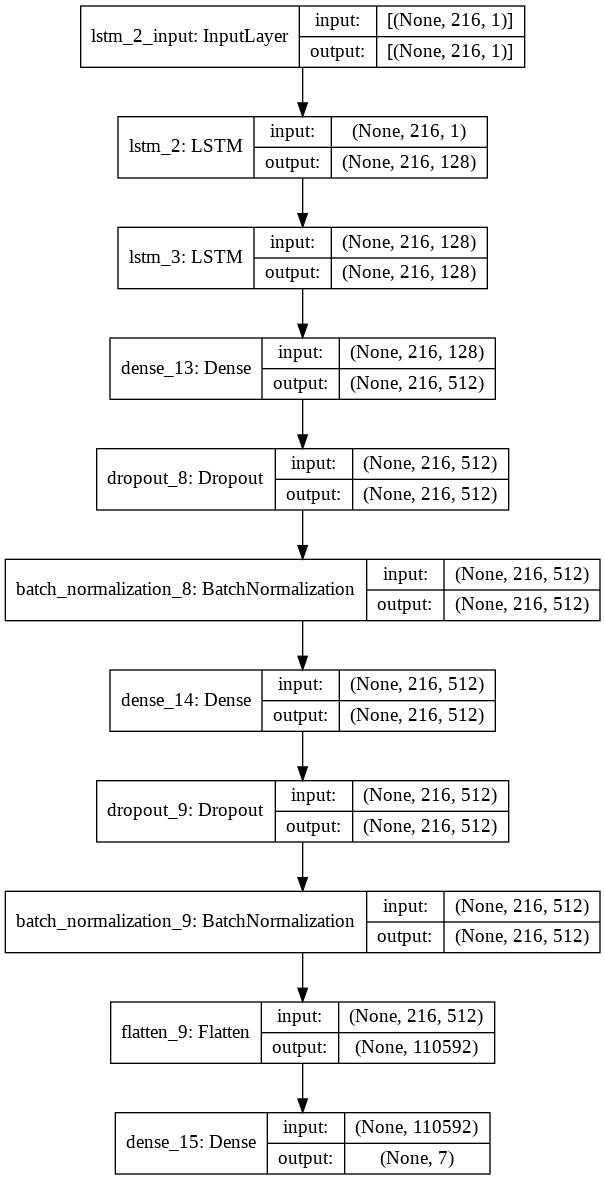

In [ ]:
plot_model(model_emotion_RNN, to_file='/content/models/model_emotion_RNN_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10)
model_gender_RNN_history = model_gender_RNN.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 9s 167ms/step - loss: 2.7420 - accuracy: 0.1126 - val_loss: 1.9345 - val_accuracy: 0.2178
Epoch 2/100
15/15 [==============================] - 2s 122ms/step - loss: 1.9975 - accuracy: 0.2889 - val_loss: 1.9211 - val_accuracy: 0.1584
Epoch 3/100
15/15 [==============================] - 2s 122ms/step - loss: 1.7584 - accuracy: 0.3619 - val_loss: 1.9106 - val_accuracy: 0.1386
Epoch 4/100
15/15 [==============================] - 2s 117ms/step - loss: 1.5796 - accuracy: 0.4371 - val_loss: 1.9028 - val_accuracy: 0.1485
Epoch 5/100
15/15 [==============================] - 2s 119ms/step - loss: 1.3731 - accuracy: 0.4869 - val_loss: 1.8953 - val_accuracy: 0.1584
Epoch 6/100
15/15 [==============================] - 2s 117ms/step - loss: 1.2716 - accuracy: 0.5392 - val_loss: 1.8908 - val_accuracy: 0.1782
Epoch 7/100
15/15 [==============================] - 2s 118ms/step - loss: 1.1941 - accuracy: 0.5883 - val_loss: 1.8840 - val_accuracy: 0.2673

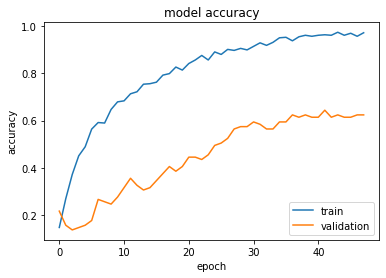

In [ ]:
PlotAcc(model_gender_RNN_history)

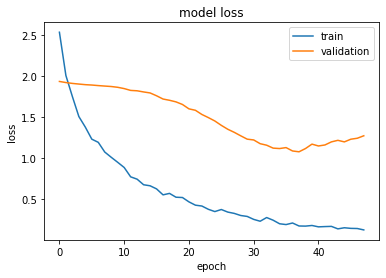

In [ ]:
PlotLoss(model_gender_RNN_history)

In [ ]:
metrics = model_gender_RNN.evaluate(X_test, y_test, batch_size=16, verbose=0)
print("Categorical Cross Entropy:", round(metrics[0],3), "\nAccuracy:", round(metrics[1],3))

Categorical Cross Entropy: 1.05 
Accuracy: 0.673


In [ ]:
model_gender_RNN_preds = GetPredictions(model_gender_RNN, X_test, y_test, lb)

7/7 [==============================] - 1s 14ms/step


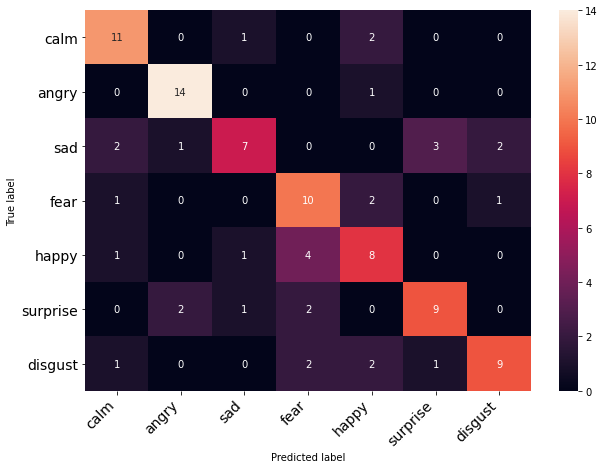

In [ ]:
print_confusion_matrix(model_gender_RNN_preds, pred="emotion")